# Application of `pyheatmy.frequency` to real MOLONARI data

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Loading the frequency module

In [22]:
from pyheatmy.frequency import frequency_analysis
fa = frequency_analysis()

Frequency analysis module initialized.
This module will analyze a multi-periodic signal to estimate attenuation and phase decay coefficients.
Using phase decay and amplitude attenuation with depth, we'll retrieve kappa_e and v_t for each dominant period.
-------------------------------------
Please use set_inputs(...) to provide the necessary data before analysis.


In [23]:
df_signals = pd.read_csv('/Users/noedaniel/Desktop/MOLONARI/MOLONARI1D/dataAnalysis/raw_data/point34_27_06_16/point34_temperature_cleaned.csv')
df_river = pd.read_csv('/Users/noedaniel/Desktop/MOLONARI/MOLONARI1D/dataAnalysis/raw_data/point34_27_06_16/point34_pression_cleaned.csv')

#df_signals = pd.read_csv('/Users/noedaniel/Desktop/MOLONARI/MOLONARI1D/dataAnalysis/raw_data/point35_07_12_16/point35_temperature_cleaned.csv')
#df_river = pd.read_csv('/Users/noedaniel/Desktop/MOLONARI/MOLONARI1D/dataAnalysis/raw_data/point35_07_12_16/point35_pression_cleaned.csv')

In [24]:
df_signals

,dates,Temp_profondeur_10,Temp_profondeur_20,Temp_profondeur_30,Temp_profondeur_40
0,27-06-2016 12:45,13.882,13.954,14.026,13.954
1,27-06-2016 13:00,13.858,13.930,14.026,13.954
2,27-06-2016 13:15,13.882,13.930,14.002,13.930
3,27-06-2016 13:30,13.882,13.930,14.002,13.930
4,27-06-2016 13:45,13.906,13.930,14.002,13.930
...,...,...,...,...,...
1266,10-07-2016 17:15,16.082,15.247,14.912,14.529
1267,10-07-2016 17:30,16.129,15.270,14.912,14.529
1268,12-07-2016 09:45,14.457,14.745,14.816,14.649
1269,12-07-2016 10:00,14.457,14.721,14.816,14.649


In [25]:
df_river['dates']

0       27-06-2016 12:45
1       27-06-2016 13:00
2       27-06-2016 13:15
3       27-06-2016 13:30
4       27-06-2016 13:45
              ...       
1266    10-07-2016 17:15
1267    10-07-2016 17:30
1268    12-07-2016 09:45
1269    12-07-2016 10:00
1270    12-07-2016 10:15
Name: dates, Length: 1271, dtype: object

In [26]:
def convertDates(df: pd.DataFrame):
    """
    Convert dates trying several explicit formats and a robust fallback.
    Works in-place on the DataFrame (assumes first column contains date strings).
    """
    times = df[df.columns[0]]

    # Candidate explicit formats (added hyphen variants)
    formats = (
        "%m/%d/%y %H:%M:%S", "%m/%d/%y %I:%M:%S %p",
        "%d/%m/%y %H:%M",    "%d/%m/%y %I:%M %p",
        "%m/%d/%Y %H:%M:%S", "%m/%d/%Y %I:%M:%S %p",
        "%d/%m/%Y %H:%M",    "%d/%m/%Y %I:%M %p",
        "%y/%m/%d %H:%M:%S", "%y/%m/%d %I:%M:%S %p",
        "%y/%m/%d %H:%M",    "%y/%m/%d %I:%M %p",
        "%Y/%m/%d %H:%M:%S", "%Y/%m/%d %I:%M:%S %p",
        "%Y/%m/%d %H:%M",    "%Y/%m/%d %I:%M %p",
        # --- hyphen variants commonly found in your files:
        "%d-%m-%Y %H:%M:%S", "%d-%m-%Y %H:%M",
        "%d-%m-%y %H:%M:%S", "%d-%m-%y %H:%M",
        "%Y-%m-%d %H:%M:%S", "%Y-%m-%d %H:%M",
        # fallback marker
        None
    )

    for f in formats:
        if f is None:
            break
        try:
            new_times = pd.to_datetime(times, format=f)
            # preserve original ordering check (optional)
            new_ts = new_times.values.astype(np.int64)
            test = np.sort(new_ts) - new_ts
            if np.sum(np.abs(test)) != 0:
                # ordering mismatch -> not this format
                raise ValueError("Order mismatch for format " + str(f))
            df[df.columns[0]] = new_times
            return
        except Exception:
            continue

    # Fallback: try generic parsing with dayfirst and infer
    # This often handles '12-07-2016 13:45' correctly.
    try:
        new_times = pd.to_datetime(times, dayfirst=True, infer_datetime_format=True, errors='raise')
        # final ordering check
        new_ts = new_times.values.astype(np.int64)
        test = np.sort(new_ts) - new_ts
        if np.sum(np.abs(test)) != 0:
            raise ValueError("Order mismatch after fallback parsing")
        df[df.columns[0]] = new_times
        return
    except Exception as e:
        # Last resort: try replacing '-' with '/' then parse
        try:
            times2 = times.astype(str).str.replace('-', '/')
            new_times = pd.to_datetime(times2, dayfirst=True, infer_datetime_format=True, errors='raise')
            new_ts = new_times.values.astype(np.int64)
            test = np.sort(new_ts) - new_ts
            if np.sum(np.abs(test)) != 0:
                raise ValueError("Order mismatch after dash->slash fallback")
            df[df.columns[0]] = new_times
            return
        except Exception:
            raise ValueError("Cannot convert dates: No known formats match your data!") from e

In [27]:
# def convertDates(df: pd.DataFrame):
#     """
#     Convert dates from a list of strings by testing several different input formats
#     Try all date formats already encountered in data points
#     If none of them is OK, try the generic way (None)
#     If the generic way doesn't work, this method fails
#     (in that case, you should add the new format to the list)
    
#     This function works directly on the giving Pandas dataframe (in place)
#     This function assumes that the first column of the given Pandas dataframe
#     contains the dates as characters string type
    
#     For datetime conversion performance, see:
#     See https://stackoverflow.com/questions/40881876/python-pandas-convert-datetime-to-timestamp-effectively-through-dt-accessor
#     """
#     formats = ("%m/%d/%y %H:%M:%S", "%m/%d/%y %I:%M:%S %p",
#                "%d/%m/%y %H:%M",    "%d/%m/%y %I:%M %p",
#                "%m/%d/%Y %H:%M:%S", "%m/%d/%Y %I:%M:%S %p", 
#                "%d/%m/%Y %H:%M",    "%d/%m/%Y %I:%M %p",
#                "%y/%m/%d %H:%M:%S", "%y/%m/%d %I:%M:%S %p", 
#                "%y/%m/%d %H:%M",    "%y/%m/%d %I:%M %p",
#                "%Y/%m/%d %H:%M:%S", "%Y/%m/%d %I:%M:%S %p", 
#                "%Y/%m/%d %H:%M",    "%Y/%m/%d %I:%M %p",
#                None)
#     times = df[df.columns[0]]
#     for f in formats:
#         try:
#             # Convert strings to datetime objects
#             new_times = pd.to_datetime(times, format=f)
#             # Convert datetime series to numpy array of integers (timestamps)
#             new_ts = new_times.values.astype(np.int64)
#             # If times are not ordered, this is not the appropriate format
#             test = np.sort(new_ts) - new_ts
#             if np.sum(abs(test)) != 0 :
#                 #print("Order is not the same")
#                 raise ValueError()
#             # Else, the conversion is a success
#             #print("Found format ", f)
#             df[df.columns[0]] = new_times
#             return
        
#         except ValueError:
#             #print("Format ", f, " not valid")
#             continue
    
#     # None of the known format are valid
#     raise ValueError("Cannot convert dates: No known formats match your data!")

In [28]:
convertDates(df_river)
convertDates(df_signals)

In [29]:
dates_river = df_river['dates']
dates_signals = df_signals['dates']

Check if dates are the same, if not we crop the data frames so that they both have the same dates

In [30]:
df_river_orig = df_river.copy()
df_signals_orig = df_signals.copy()

# Find intersection of dates (keep ordering consistent with df_river_orig)
common_set = set(df_river_orig['dates']).intersection(set(df_signals_orig['dates']))
if len(common_set) == 0:
    raise RuntimeError("No common timestamps found between df_river and df_signals!")

common = pd.Series(pd.to_datetime(sorted(list(common_set))))

# Build cropped, date-sorted dataframes
df_river_common = df_river_orig[df_river_orig['dates'].isin(common)].sort_values('dates').reset_index(drop=True)
df_signals_common = df_signals_orig[df_signals_orig['dates'].isin(common)].sort_values('dates').reset_index(drop=True)

# Optionally replace the working names so downstream cells use the cropped data
df_river = df_river_common.copy()
df_signals = df_signals_common.copy()

# Masks / leftover series for diagnostics
common_dates = df_river_orig['dates'].isin(common)            # boolean mask relative to original river df
river_only = df_river_orig[~common_dates]['dates'].reset_index(drop=True)
signals_only = df_signals_orig[~df_signals_orig['dates'].isin(common)]['dates'].reset_index(drop=True)

# Quick summary
print(f"Common timestamps: {len(common)}")
print(f"df_river original: {len(df_river_orig)} rows, df_signals original: {len(df_signals_orig)} rows")
print(f"After cropping -> df_river: {len(df_river)}, df_signals: {len(df_signals)}")
print(f"First/Last common timestamp: {common.iloc[0]}  ->  {common.iloc[-1]}")
if len(river_only):
    print(f"River-only timestamps: {len(river_only)} (first few):\n{river_only.head()}")
if len(signals_only):
    print(f"Signals-only timestamps: {len(signals_only)} (first few):\n{signals_only.head()}")

Common timestamps: 1271
df_river original: 1271 rows, df_signals original: 1271 rows
After cropping -> df_river: 1271, df_signals: 1271
First/Last common timestamp: 2016-06-27 12:45:00  ->  2016-07-12 10:15:00


In [31]:
dates = df_river['dates']
signals = [df_river['temperature_stream'].values,
           df_signals['Temp_profondeur_10'].values, 
           df_signals['Temp_profondeur_20'].values, 
           df_signals['Temp_profondeur_30'].values, 
           df_signals['Temp_profondeur_40'].values]

signals = [np.array(signal) for signal in signals]

depths = [0, 0.1, 0.2, 0.3, 0.4]

In [32]:
df_river

,dates,temperature_stream,dH
0,2016-06-27 12:45:00,13.939,-0.009914
1,2016-06-27 13:00:00,13.967,-0.009230
2,2016-06-27 13:15:00,13.985,-0.006942
3,2016-06-27 13:30:00,14.021,-0.005866
4,2016-06-27 13:45:00,14.062,-0.005148
...,...,...,...
1266,2016-07-10 17:15:00,17.454,-0.028522
1267,2016-07-10 17:30:00,17.526,-0.028634
1268,2016-07-12 09:45:00,14.255,-0.028140
1269,2016-07-12 10:00:00,14.279,-0.028062


Text(0.5, 1.0, 'River Charge Sensor Data')

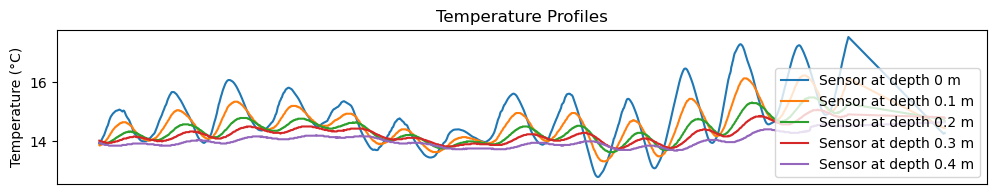

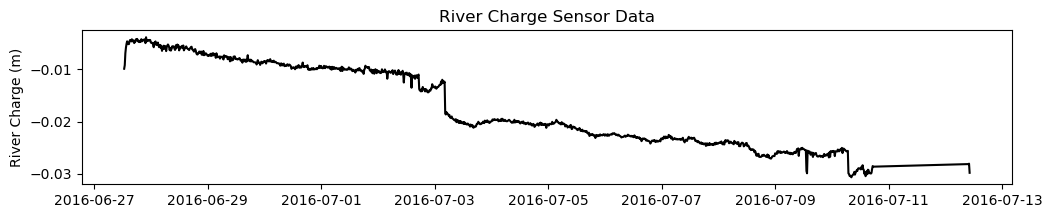

In [33]:
plt.figure(figsize=(12, 2))
for i, signal in enumerate(signals):
    plt.plot(dates, signal, label=f'Sensor at depth {depths[i]} m')

plt.xticks([])
#plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Profiles')
plt.legend()

plt.figure(figsize=(12, 2))
plt.plot(dates, df_river['dH'].values, label='River charge Sensor', color='black')
plt.ylabel('River Charge (m)')
plt.title('River Charge Sensor Data')

Now try to launch frequential analysis.

In [34]:
fa.set_inputs(dates=dates, signals=signals, depths=depths)

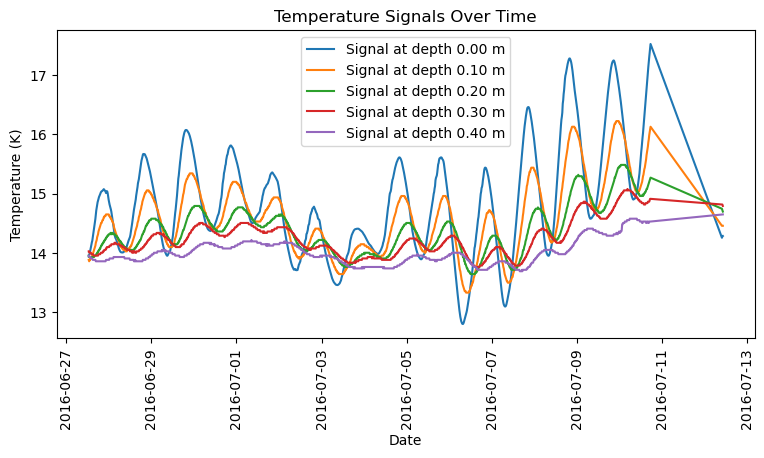

In [35]:
fa.plot_signals()

/Users/noedaniel/Desktop/MOLONARI/MOLONARI1D/pyheatmy/pyheatmy/frequency.py:447: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1.0 / (freqs * 86400.0), amp, label=f'Sensor at depth {depths[i]} m')


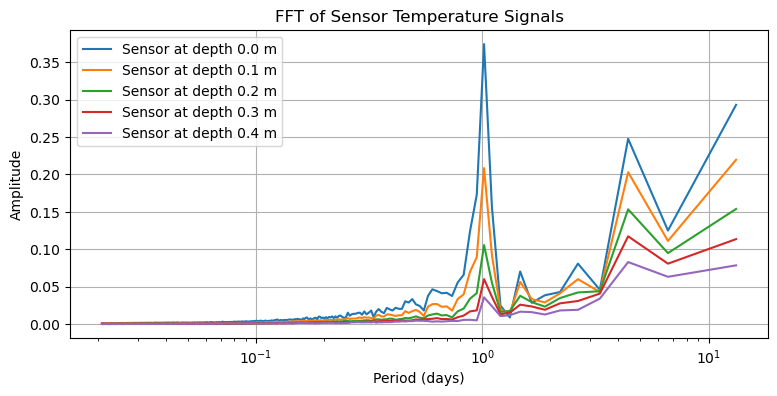

In [36]:
fa.fft_sensors()

We have to manually change the acceptance parameters otherwise, the point will not be detected.

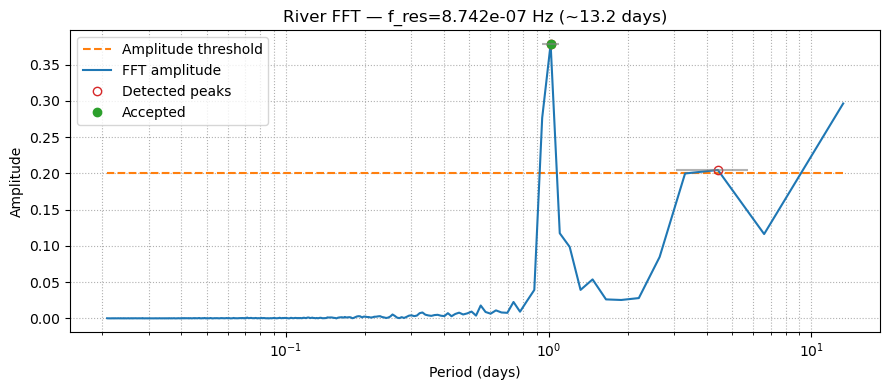

In [37]:
Pd, f0, A0, meta = fa.find_dominant_periods(store=True, compute_phases=True, amplitude_threshold=0.2, Q_min=5)

This deals only with 1D attenuation (no lateral flow).
Detected depths: [0.  0.1 0.2 0.3 0.4]
Amplitudes at dominant periods for each signal computed.
Period 1.02 days: Amplitudes = [0.37406868 0.20845111 0.10564464 0.06009539 0.03574166]


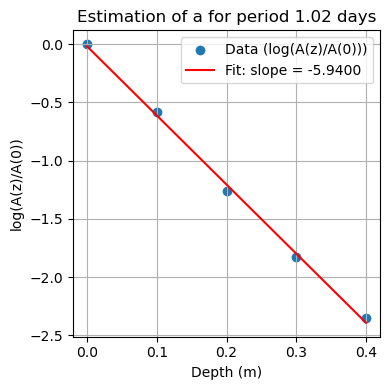

Attenuation coefficients a estimated for each dominant period.
Period 1.02 days: a = 5.9400 1/m
Period 1.02 days: R^2 = 0.9979


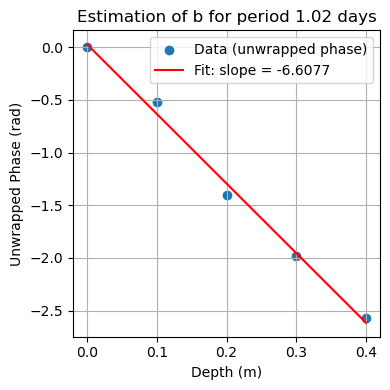

Phase decay coefficients b estimated for each dominant period.
Period 1.02 days: b = 6.6077 rad/m
Period 1.02 days: R^2 = 0.9937


In [38]:
a_est, a_R2 = fa.estimate_a(draw=True)     # lit dates/signals/depths/Pd depuis le state
b_est, b_R2 = fa.estimate_b(draw=True)                    # idem

Now we can retrieve the $\kappa_e$ and $v_t$ values

In [39]:
kappa_e, v_t = fa.perform_inversion(verbose=True)         # lit a,b,Pd du state

Inversion complete.
Period 1.02 days: kappa_e = 8.131e-07 m^2/s, v_t = 1.147e-06 m/s


### Checking dimension

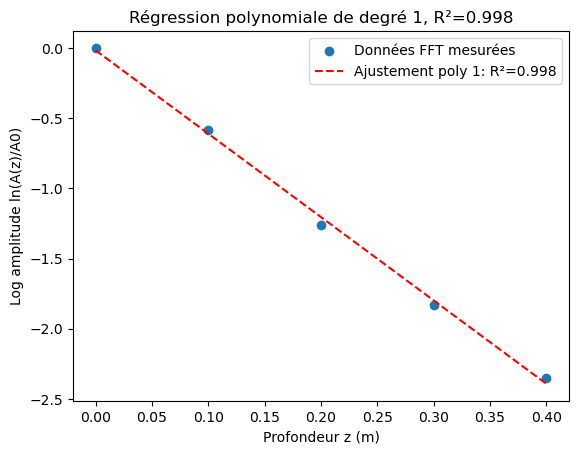

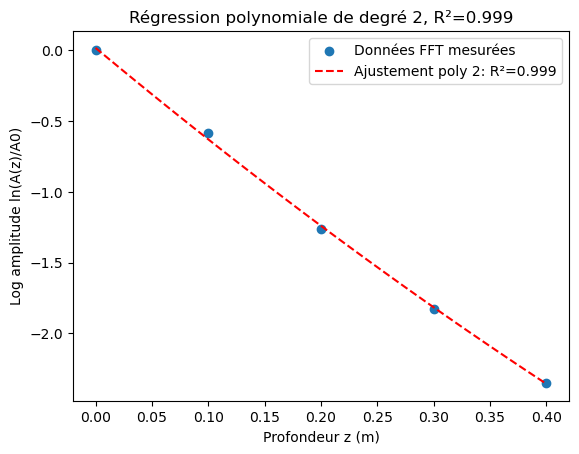

Best model: 1D


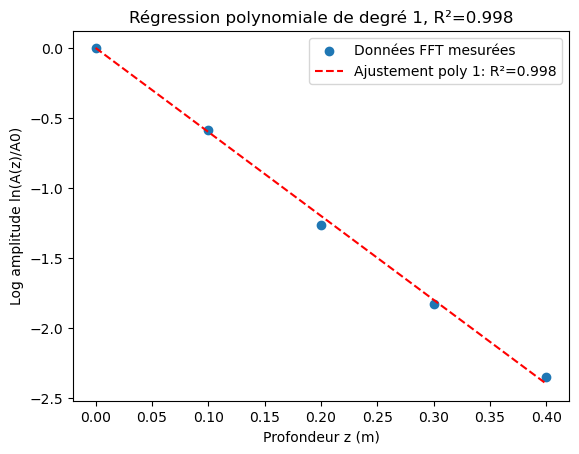

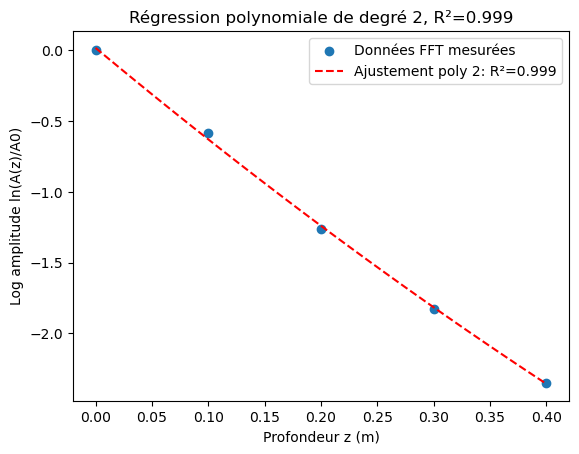

Best model with intercept: 1D


In [46]:
modele = fa.critere_2D(show_reg=True, intercept=False)
print("Best model:", modele["modele"])
modele_intercept = fa.critere_2D(intercept=True, show_reg=True)
print("Best model with intercept:", modele_intercept["modele"])

### Checking if inversion is close

In [40]:
df_signals

,dates,Temp_profondeur_10,Temp_profondeur_20,Temp_profondeur_30,Temp_profondeur_40
0,2016-06-27 12:45:00,13.882,13.954,14.026,13.954
1,2016-06-27 13:00:00,13.858,13.930,14.026,13.954
2,2016-06-27 13:15:00,13.882,13.930,14.002,13.930
3,2016-06-27 13:30:00,13.882,13.930,14.002,13.930
4,2016-06-27 13:45:00,13.906,13.930,14.002,13.930
...,...,...,...,...,...
1266,2016-07-10 17:15:00,16.082,15.247,14.912,14.529
1267,2016-07-10 17:30:00,16.129,15.270,14.912,14.529
1268,2016-07-12 09:45:00,14.457,14.745,14.816,14.649
1269,2016-07-12 10:00:00,14.457,14.721,14.816,14.649


In [41]:
df_river

,dates,temperature_stream,dH
0,2016-06-27 12:45:00,13.939,-0.009914
1,2016-06-27 13:00:00,13.967,-0.009230
2,2016-06-27 13:15:00,13.985,-0.006942
3,2016-06-27 13:30:00,14.021,-0.005866
4,2016-06-27 13:45:00,14.062,-0.005148
...,...,...,...
1266,2016-07-10 17:15:00,17.454,-0.028522
1267,2016-07-10 17:30:00,17.526,-0.028634
1268,2016-07-12 09:45:00,14.255,-0.028140
1269,2016-07-12 10:00:00,14.279,-0.028062


In [42]:
# après vous être assuré que df_river['dates'] et df_signals['dates'] sont datetime
dH_measures = [
    (row['dates'], (row['dH'], row['temperature_stream']))
    for _, row in df_river.iterrows()
]

sensor_cols = ['Temp_profondeur_10','Temp_profondeur_20','Temp_profondeur_30','Temp_profondeur_40']

# solution de repli : prendre la dernière sonde comme 'aquifer' si pas de colonne T_aq
if 'T_aq' not in df_signals.columns:
    df_signals['T_aq'] = df_signals[sensor_cols[-1]]

T_measures = [
    (row['dates'], np.array([ *(row[c] for c in sensor_cols), row['T_aq'] ]))
    for _, row in df_signals.iterrows()
]

In [43]:
from pyheatmy import *

In [44]:
# Define sensor/column geometry so lengths match what Column expects:
# Column expects: len(_real_z) == 2 + n_sensors -> depth_sensors must have length n_sensors + 1
Zbottom = 0.4
# sensor_cols must match the temperature columns used to build T_measures
sensor_cols = ['Temp_profondeur_10','Temp_profondeur_20','Temp_profondeur_30','Temp_profondeur_40']
# depths of the sensors (one value per sensor, order must match sensor_cols)
sensor_depths = [0.1, 0.2, 0.3, 0.4]
# depth of the aquifer (T_aq). It must be appended to the sensor depth list so that
# depth_sensors has length n_sensors + 1 (sensors + aquifer) as expected by Column.__init__
aquifer_depth = 1.0  # you can change this to the real aquifer depth if known
depth_sensors = sensor_depths + [aquifer_depth]
# Sanity checks and diagnostics before building the Column
n_sensors = len(sensor_cols)
print('n_sensors =', n_sensors)
print('len(depth_sensors) =', len(depth_sensors), '(should be n_sensors + 1)')
print('example T_measures[0] length =', len(T_measures[0]) if len(T_measures) else 'T_measures empty')
assert len(depth_sensors) == 1 + n_sensors, f'depth_sensors must have length n_sensors+1 (got {len(depth_sensors)} vs {1+n_sensors})'

col_dict = {
	"river_bed": 1., 
    "depth_sensors": depth_sensors,
	"offset": .0,
    "dH_measures": dH_measures,
	"T_measures": T_measures,
    "sigma_meas_P": None,
    "sigma_meas_T": None,
    "inter_mode": 'lagrange'
}

col = Column.from_dict(col_dict)

n_sensors = 4
len(depth_sensors) = 5 (should be n_sensors + 1)
example T_measures[0] length = 2


[Prior sur une valeure qui évolue entre 11 et 16 avec un écart type de 0.01, Prior sur une valeure qui évolue entre 0.01 et 0.25 avec un écart type de 0.01, Prior sur une valeure qui évolue entre 1 et 10 avec un écart type de 0.1, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0 avec un écart type de 100000.0, Prior sur une valeure qui évolue entre 1e-09 et 1e-05 avec un écart type de 1e-10]
Initialisation - Utilisation de la mémoire (en Mo) : 288.768


Burn in phase: 100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Initialisation post burn-in - Utilisation de la mémoire (en Mo) : 112.115712
DREAM MCMC Computation: 100%|██████████| 30/30 [00:39<00:00,  1.30s/it]


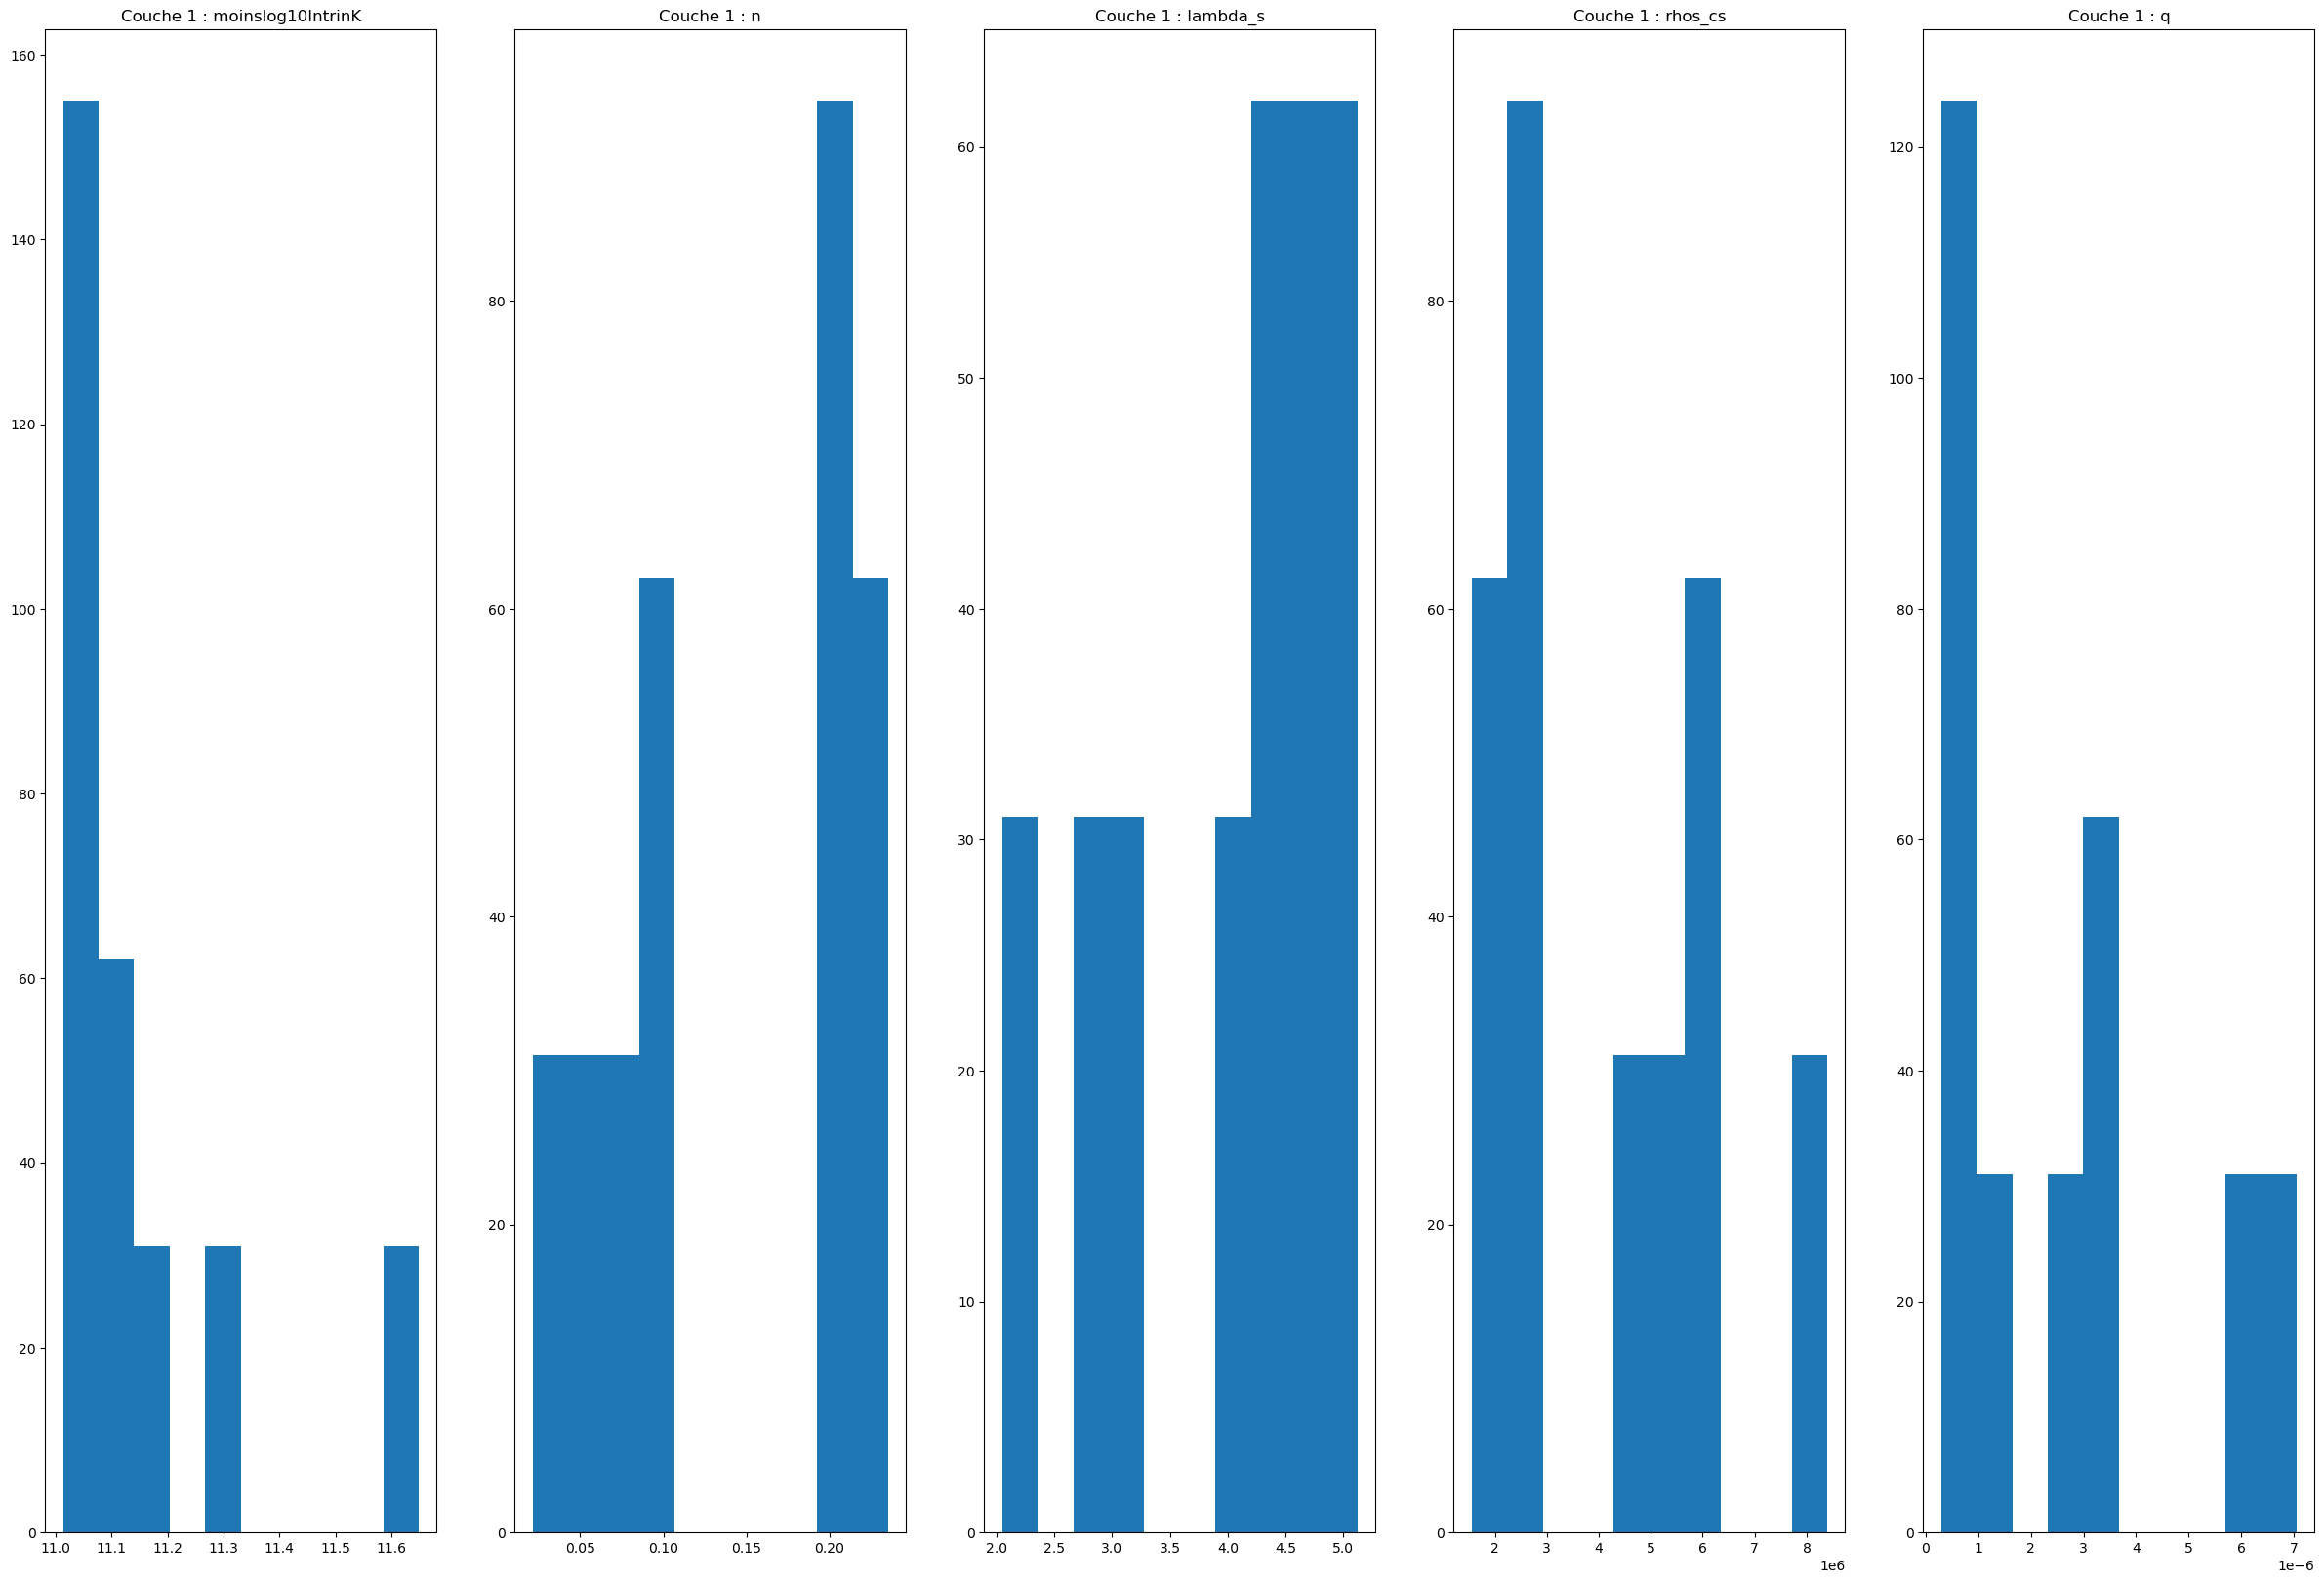

In [45]:
NBITERMCMC = 30

priors = {
    "Prior_moinslog10IntrinK": ((4+7, 9+7), .01), # (intervalle, sigma)
    "Prior_n": ((.01, .25), .01),
    "Prior_lambda_s": ((1, 10), .1),
    "Prior_rhos_cs": ((1e6,1e7), 1e5),
    "Prior_q": ((1e-9, 1e-5), 1e-10),
}

Layer_homogenous = {
    "name": "Layer_homogenous",
    "zLow": Zbottom,
    "moinslog10IntrinK": 11,
    "n": .1,
    "lambda_s": 2,
    "rhos_cs": 4e6,
    "q": 1e-5
}

Layer_homogenous = Layer.from_dict(Layer_homogenous)

col.set_layers(Layer_homogenous)
Layer_homogenous.set_priors_from_dict(priors)
print(Layer_homogenous.Prior_list)


col.all_layers

col.compute_mcmc(
    nb_iter = NBITERMCMC,
    verbose=False
)

bestLayers = col.get_best_layers()

col.plot_all_param_pdf()


In [51]:
#print(Layer_homogenous.params)
MOINSLOG10INTRINK = Layer_homogenous.params[0]
POROSITE = Layer_homogenous.params[1]
LAMBDA_S = Layer_homogenous.params[2]
RHOS_CS = Layer_homogenous.params[3]
Q = Layer_homogenous.params[4]

print("Estimated parameters from MCMC inversion:")
print(f"MOINSLOG10INTRINK: {MOINSLOG10INTRINK}")
print(f"POROSITE: {POROSITE}")
print(f"LAMBDA_S: {LAMBDA_S}")
print(f"RHOS_CS: {RHOS_CS}")
print(f"Q: {Q}")

Estimated parameters from MCMC inversion:
MOINSLOG10INTRINK: 11.026941299438477
POROSITE: 0.20653605461120605
LAMBDA_S: 2.7389023303985596
RHOS_CS: 1788028.0
Q: 3.6068231565877795e-06


--- Compute Solve Transi ---
One layer : moinslog10IntrinK = 11.026941299438477, n = 0.20653605461120605, lambda_s = 2.7389023303985596, rhos_cs = 1788028.0, q = 3.6068231565877795e-06
Solving the flow with intrinsec permeability 9.39850367670525e-12, and permeability 9.219931962434202e-05
Done.


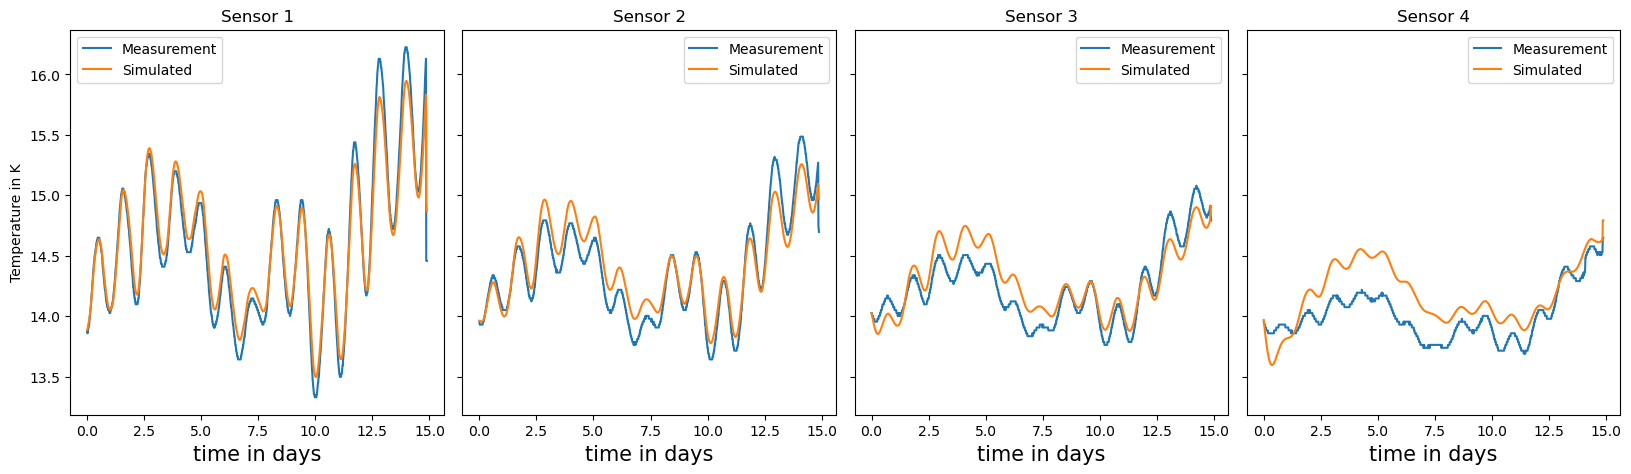

In [52]:
col.compute_solve_transi()
col.plot_compare_temperatures_sensors()


In [53]:
def effective_params(
        lambda_s,          # [W/m/K] conductivity of solid
        rho_c_s,           # [J/m³/K] volumetric heat capacity of solid
        k,                 # [m²] intrinsic permeability
        n,                 # [-] porosity
        gradH,             # [-] hydraulic head gradient (positive downward)
        # --- constants for water at 20°C
        lambda_w=0.6,      # [W/m/K]
        rho_w=1000.0,      # [kg/m³]
        c_w=4182.0,        # [J/kg/K]
        mu_w=1.002e-3,     # [Pa·s]
        g=9.81             # [m/s²]
        ):
        """
        Compute effective thermal diffusivity (kappa_e) and thermal advective velocity (v_t)
        from solid properties, porosity, intrinsic permeability and head gradient.

        Parameters
        ----------
        lambda_s : float
            Thermal conductivity of solid [W/m/K]
        rho_c_s : float
            Volumetric heat capacity of solid [J/m³/K]
        k : float
            Intrinsic permeability [m²]
        n : float
            Porosity [-]
        gradH : float
            Hydraulic head gradient (∂H/∂z) [-] (positive downward)

        Returns
        -------
        kappa_e : float
            Effective thermal diffusivity [m²/s]
        v_t : float
            Effective thermal advective velocity [m/s]
        """

        rho_c_w = rho_w * c_w  # [J/m³/K]
        rho_c_m = n * rho_c_w + (1 - n) * rho_c_s  # [J/m³/K]
        lambda_m = (n * np.sqrt(lambda_w) + (1 - n) * np.sqrt(lambda_s)) ** 2  # [W/m/K]

        kappa_e = lambda_m / rho_c_m  # [m²/s]

        # Convert intrinsic permeability to hydraulic conductivity
        K = k * rho_w * g / mu_w  # [m/s]

        v_t = - (rho_c_w / rho_c_m) * K * gradH  # [m/s]

        return kappa_e, v_t

In [54]:
kappa_e, _ = effective_params(
    lambda_s=LAMBDA_S,
    rho_c_s=RHOS_CS,
    k=10**(-MOINSLOG10INTRINK),
    n=POROSITE,
    gradH=0  # example head gradient
)

In [55]:
print(kappa_e)

9.507808442770281e-07


In [56]:
kappa_e = fa.perform_inversion(verbose=True)         # lit a,b,Pd du state

Inversion complete.
Period 1.02 days: kappa_e = 8.131e-07 m^2/s, v_t = 1.147e-06 m/s


Donc on a pas les mêmes paramètres.